## KHỞI TẠO THƯ VIỆN

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from imutils import contours

##Load ảnh


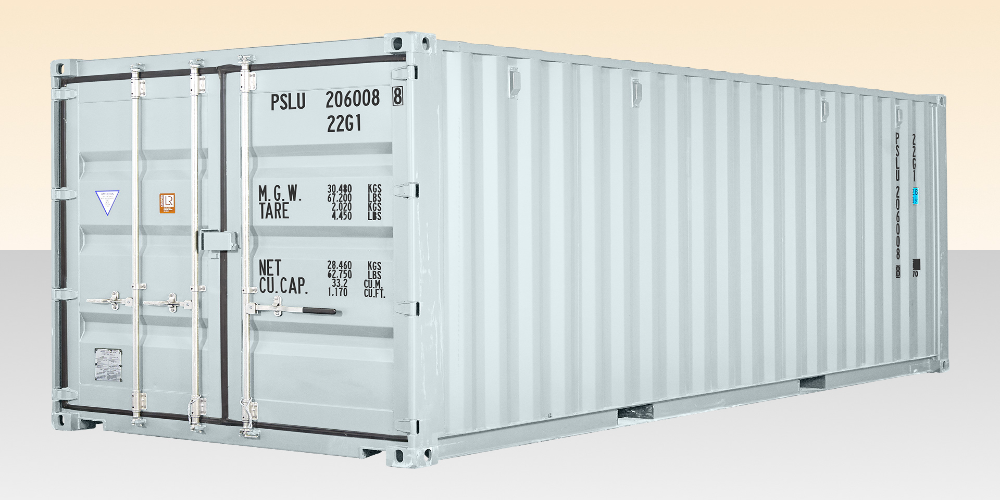

In [8]:
path = "drive/MyDrive/colab/"
img_path = path+ "image/container1.png"
img = cv2.imread(img_path)
img = cv2.resize(img,(1000,500))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

##read pretrained yolo model

In [4]:
classes_path = path + "yolo/yolov4.txt"
weights_path = path+ "yolo/yolov4.weights"
config_path = path + "yolo/yolov4.cfg"

def build_model(classes_path=classes_path, weights_path=weights_path, config_path=config_path):
    # read class names from text file
    with open(classes_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    # read pre-trained model and config file to create the network
    net = cv2.dnn.readNet(weights_path, config_path)
    layer_names = net.getLayerNames() 
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()] 
    return net, classes, output_layers

net, classes, output_layers = build_model()

##detect and crop code area

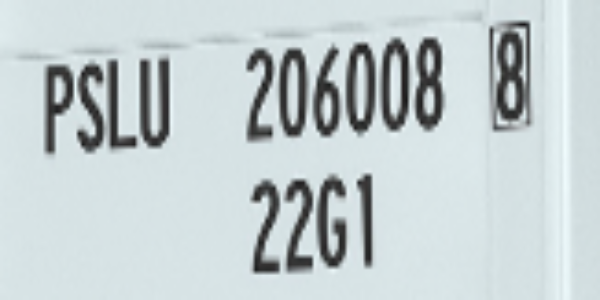

True

In [9]:
def detect(net, frame, output_layers):
    # initialization
    class_ids = []
    confidences = []
    boxes = []
    CONFIDENCE_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    scale = 1/255
    size = (320, 320)
    # create input blob to prepare image for the network
    blob = cv2.dnn.blobFromImage(frame, scalefactor=scale, size=size, mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    im_h, im_w = frame.shape[0:2]
    # run inference through the network and gather predictions from output layers
    outs = net.forward(output_layers)
    if outs:
    # for each detection from each output layer, get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    # convert yolo coords to opencv coords
                    center_x = int(detection[0] * im_w)
                    center_y = int(detection[1] * im_h)
                    w = int(detection[2] * im_w)
                    h = int(detection[3] * im_h)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
        # apply non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
         # clean up
        clean_class_ids = []
        clean_confidences = []
        clean_boxes = []
        for i in indices:
            j = i
            clean_class_ids.append(class_ids[j])
            clean_boxes.append(boxes[j])
            clean_confidences.append(confidences[j])
        return clean_class_ids, clean_boxes, clean_confidences


def crop(frame, boxes):
    x,y,w,h = boxes[0]
    cropped = frame[round(y):round(y+h)+1,round(x):round(x+w)+1]
    return cropped

class_ids, boxes,_ = detect(net, img, output_layers)
code_reg = crop(img, boxes)
height,width,_ = code_reg.shape
if height > width:
    height = 600
    width = 300
else:
    height = 300
    width = 600
code_reg = cv2.resize(code_reg, (width,height))
cv2_imshow(code_reg)
cv2.imwrite(path+'image/code_reg.png',code_reg)

##Load pretrained EfficientNetB0

In [6]:
labels = [
    '0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G',
    'H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'
    ]

MODEL_PATH = path+ 'EfficientNetB0/trained_model'
model = load_model(MODEL_PATH, compile=False)

##Regconize character


1/1 [==============================] - 0s 73ms/step


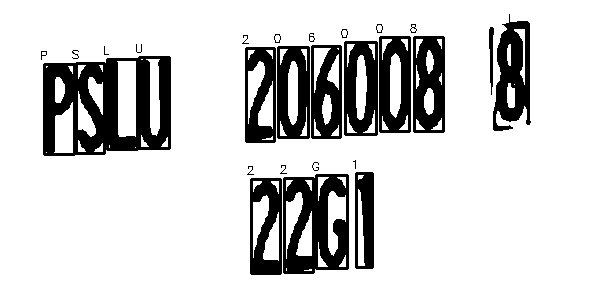

True

In [10]:
code_reg = cv2.cvtColor(code_reg,cv2.COLOR_RGB2GRAY)
_, code_reg = cv2.threshold(code_reg, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)
if code_reg[0,0] == 0:
  code_reg = ~code_reg
bw = code_reg.copy()
mask = cv2.Canny(code_reg, 120, 255)
cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts,_ = contours.sort_contours(cnts)

for idx in range(len(cnts)):
    x, y, w, h = cv2.boundingRect(cnts[idx])
    #remove box to small or to large or near edge of image
    if  w > 10 and h > 10 and w < 100 and h < 100 and x > 5 and y > 5 and (y + h) < (height-5) and (x+w) < (width-5):
        crop_img = bw[y:y + h -2 , x:x + w -2 ]
        crop_img = cv2.cvtColor(crop_img,cv2.COLOR_GRAY2BGR)

        # create new image of desired size and color for padding
        old_image_height, old_image_width, channels = crop_img.shape
        new_image_width = old_image_width + 20
        new_image_height = old_image_height + 20
        color = (255,255,255)
        result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

        # compute center offset
        x_center = (new_image_width - old_image_width) // 2
        y_center = (new_image_height - old_image_height) // 2

         # copy img image into center of result image
        result[y_center:y_center+old_image_height, 
        x_center:x_center+old_image_width] = crop_img

        char = cv2.resize(result,(224,224))
        char = char.astype("float") / 255.0
        char = img_to_array(char)
        char = np.expand_dims(char, axis=0)
        prob = model.predict(char)
        idx = np.argmax(prob)
        if height > width:
            cv2.putText(code_reg,labels[idx],(x-12,y+12),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,0,0),1)
        else:
            cv2.putText(code_reg,labels[idx],(x-5,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(0,0,0),1)
        cv2.rectangle(code_reg,(round(x),round(y)),(round(x+w),round(y+h)),(0,0,0),2)

cv2_imshow(code_reg)
cv2.imwrite(path+'result/container.png',code_reg)